# Load Data

In [1]:
from data_loader import load_data
from features import generate_feature
from models import modeling
from pricing.optimizer import optimize_price_plan
import matplotlib.pyplot as plt
import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
df0 = load_data()
df0.head()

,date,store_id,sku_id,base_price,promo_flag,promo_depth,final_price,competitor_price,holiday_flag,weather_index,week_of_year,units_sold,revenue,margin,stock_cap,stockout_flag,set
0,2024-01-01,S01,SKU001,10.49,0.0,0.0,10.49,10.02,1.0,0.291,0,2,20.98,12.58,71,0,train
1,2024-01-01,S01,SKU002,15.49,0.0,0.0,15.49,15.04,1.0,0.291,0,12,185.88,105.48,78,0,train
2,2024-01-01,S01,SKU003,21.99,0.0,0.0,21.99,21.20,1.0,0.291,0,9,197.91,112.41,94,0,train
3,2024-01-01,S02,SKU001,10.49,1.0,0.1,9.44,10.30,1.0,0.291,0,22,207.68,115.28,79,0,train
4,2024-01-01,S02,SKU002,15.49,0.0,0.0,15.49,16.45,1.0,0.291,0,22,340.78,193.38,68,0,train


In [3]:
df0 = generate_feature(df0)

In [4]:
len(df0)

5490

In [5]:
df0.columns

Index(['date', 'store_id', 'sku_id', 'base_price', 'promo_flag', 'promo_depth',
       'final_price', 'competitor_price', 'holiday_flag', 'weather_index',
       'week_of_year', 'units_sold', 'revenue', 'margin', 'stock_cap',
       'stockout_flag', 'set', 'day_of_week', 'month_of_year', 'season',
       'sold_yesterday', 'sold_last_week', 'units_sold_ma7', 'units_sold_ma30',
       'final_price_ln', 'competitor_price_diff', 'flag_promo_1stday',
       'onehot_monday', 'onehot_tuesday', 'onehot_wednesday',
       'onehot_thursday', 'onehot_friday', 'onehot_saturday', 'onehot_sunday',
       'onehot_january', 'onehot_february', 'onehot_march', 'onehot_april',
       'onehot_may', 'onehot_june', 'onehot_july', 'onehot_august',
       'onehot_september', 'onehot_october', 'onehot_november',
       'onehot_december', 'onehot_spring', 'onehot_summer', 'onehot_autumn',
       'onehot_winter'],
      dtype='object')

In [6]:
df0.dtypes

date                     datetime64[ns]
store_id                       category
sku_id                         category
base_price                      float64
promo_flag                      float64
promo_depth                     float64
final_price                     float64
competitor_price                float64
holiday_flag                    float64
weather_index                   float64
week_of_year             string[python]
units_sold                        Int64
revenue                  string[python]
margin                   string[python]
stock_cap                string[python]
stockout_flag                     Int64
set                      string[python]
day_of_week                    category
month_of_year                  category
season                         category
sold_yesterday                    Int64
sold_last_week                    Int64
units_sold_ma7                  float64
units_sold_ma30                 float64
final_price_ln                  float64


In [7]:
df0['stock_cap'] = df0['stock_cap'].astype('Int64')

In [8]:
df0.head()

,date,store_id,sku_id,base_price,promo_flag,promo_depth,final_price,competitor_price,holiday_flag,weather_index,...,onehot_july,onehot_august,onehot_september,onehot_october,onehot_november,onehot_december,onehot_spring,onehot_summer,onehot_autumn,onehot_winter
0,2024-01-01,S01,SKU001,10.49,0.0,0.0,10.49,10.02,1.0,0.291,...,0,0,0,0,0,0,0,0,0,1
1,2024-01-02,S01,SKU001,10.49,0.0,0.0,10.49,10.54,0.0,0.459,...,0,0,0,0,0,0,0,0,0,1
2,2024-01-03,S01,SKU001,10.49,0.0,0.0,10.49,10.60,0.0,0.337,...,0,0,0,0,0,0,0,0,0,1
3,2024-01-04,S01,SKU001,10.49,0.0,0.0,10.49,10.99,0.0,0.381,...,0,0,0,0,0,0,0,0,0,1
4,2024-01-05,S01,SKU001,10.49,0.0,0.0,10.49,11.55,0.0,0.398,...,0,0,0,0,0,0,0,0,0,1


In [9]:
df0[df0.set == 'train']['date'].max()

Timestamp('2024-09-30 00:00:00')

In [10]:
df0[df0.set == 'test']['date'].min()

Timestamp('2024-10-01 00:00:00')

- The model will be unable to model the seasonality effect of Oct, Nov, Dec
- For product that is strongly affected by seasons, overfit can occur

In [11]:
# df0['cost_proxy'] = (df0.revenue - df0.margin) / df0.units_sold

# EDA
- Identify main demand drivers (price, promo, holiday, weather, weekly/annual patterns, store effects).
- Check price elasticity by SKU and promo effect sizes.
- Detect stockouts and discuss their impact on demand estimation.

## Quick check datastats

In [12]:
# we dont want stockout to negatively affect model performance
df = df0[df0.stockout_flag == 0].reset_index(drop = True).copy()

In [13]:
# there are still enough sample size after excluding stock out days
df.groupby(['store_id','sku_id'])['units_sold'].count()

store_id  sku_id
S01       SKU001    354
          SKU002    355
          SKU003    348
S02       SKU001    341
          SKU002    336
          SKU003    338
S03       SKU001    329
          SKU002    323
          SKU003    334
S04       SKU001    310
          SKU002    303
          SKU003    311
S05       SKU001    284
          SKU002    296
          SKU003    301
Name: units_sold, dtype: Int64

In [14]:
df.groupby(['store_id','sku_id'])['units_sold'].mean()

store_id  sku_id
S01       SKU001    17.926554
          SKU002    18.611268
          SKU003    16.227011
S02       SKU001    21.357771
          SKU002    22.458333
          SKU003    20.171598
S03       SKU001    26.194529
          SKU002    26.885449
          SKU003    23.302395
S04       SKU001    30.974194
          SKU002    31.518152
          SKU003    27.192926
S05       SKU001    34.147887
          SKU002    35.081081
          SKU003    31.813953
Name: units_sold, dtype: Float64

In [15]:
df.groupby(['store_id','sku_id'])['stock_cap'].mean()

store_id  sku_id
S01       SKU001     64.70339
          SKU002    63.997183
          SKU003    64.793103
S02       SKU001    65.821114
          SKU002    64.571429
          SKU003    63.470414
S03       SKU001    64.978723
          SKU002    65.473684
          SKU003    67.311377
S04       SKU001    70.919355
          SKU002    68.891089
          SKU003    67.376206
S05       SKU001    68.140845
          SKU002    69.804054
          SKU003    64.750831
Name: stock_cap, dtype: Float64

In [16]:
df.groupby(['store_id','sku_id'])['base_price'].mean()

store_id  sku_id
S01       SKU001    10.49
          SKU002    15.49
          SKU003    21.99
S02       SKU001    10.49
          SKU002    15.49
          SKU003    21.99
S03       SKU001    10.49
          SKU002    15.49
          SKU003    21.99
S04       SKU001    10.49
          SKU002    15.49
          SKU003    21.99
S05       SKU001    10.49
          SKU002    15.49
          SKU003    21.99
Name: base_price, dtype: float64

- Sales Store 5 > Store 4 > Store 3 > Store 2 > Store 1
- Need to distinguish 5 stores in the analysis and modeling

In [17]:
stores = list(df['store_id'].unique())
skus = list(df['sku_id'].unique())

In [18]:
stores

['S01', 'S02', 'S03', 'S04', 'S05']

In [19]:
skus

['SKU001', 'SKU002', 'SKU003']

### Price ~ Demand
There is a negative relationship

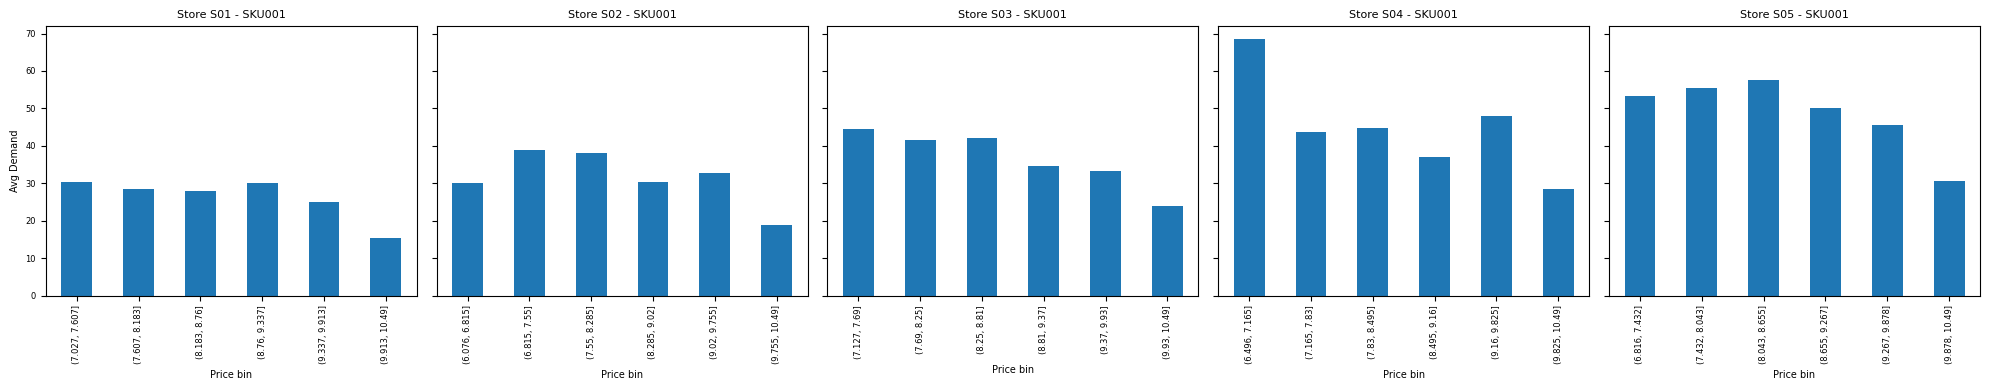

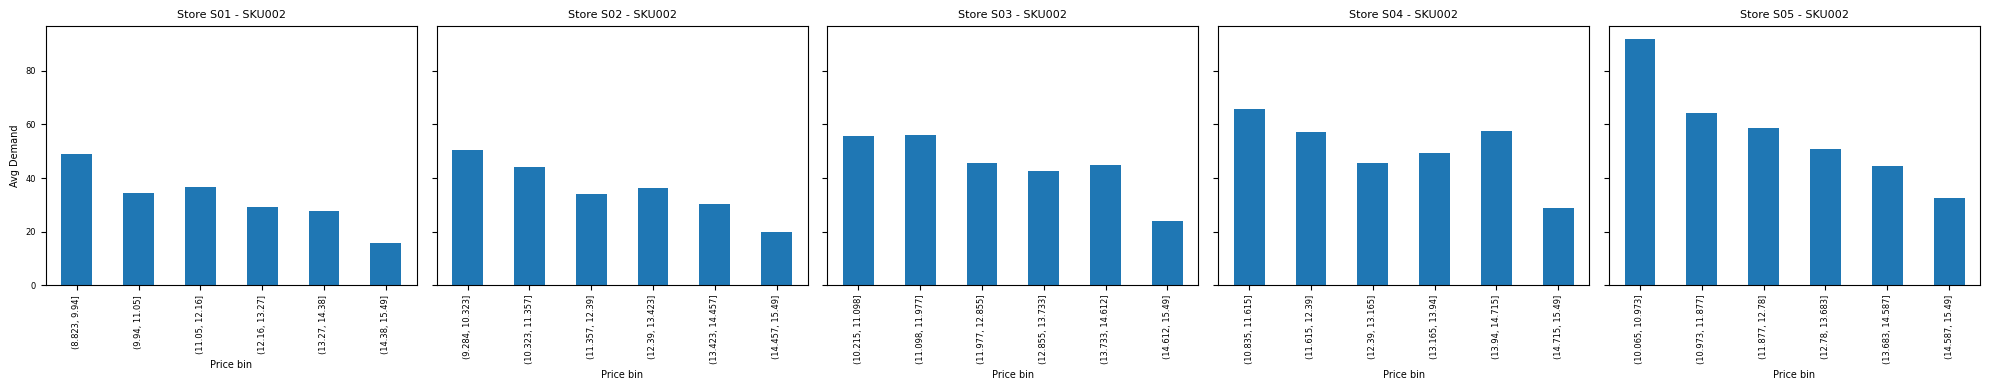

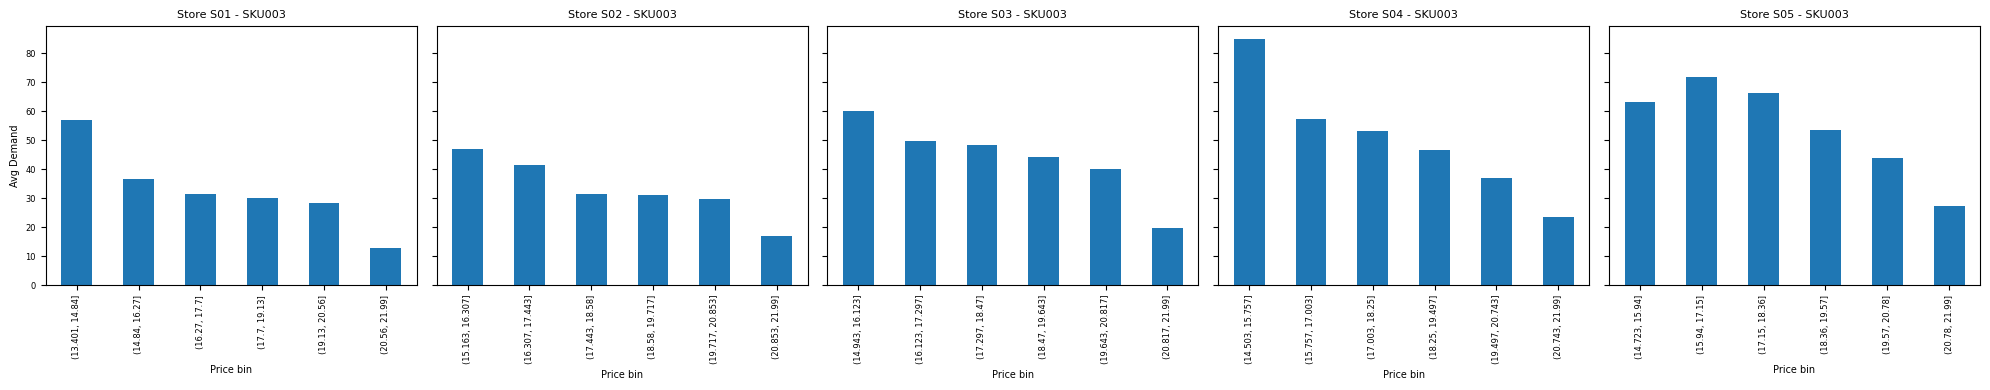

In [26]:
for sk in skus:
    n_stores = len(stores)
    fig, axes = plt.subplots(1, n_stores, figsize=(4*n_stores, 4), sharey=True)

    if n_stores == 1:  # if only 1 store, axes won't be iterable
        axes = [axes]

    for ax, st in zip(axes, stores):
        df_price = df[(df.store_id == st) & (df.sku_id == sk)]

        if df_price.empty:
            ax.set_title(f"Store {st} - {sk}\n(no data)", fontsize=8)
            ax.axis("off")
            continue

        avg = df_price.groupby(pd.cut(df_price["final_price"], bins=6))["units_sold"].mean()
        avg.plot(kind="bar", ax=ax)

        ax.set_title(f"Store {st} - {sk}", fontsize=8)
        ax.set_xlabel("Price bin", fontsize=7)
        ax.set_ylabel("Avg Demand", fontsize=7)
        ax.tick_params(axis="x", labelsize=6)
        ax.tick_params(axis="y", labelsize=6)

    plt.tight_layout()
    plt.show()


### Promo ~ Demand
Overall, bigger promotion percentage does drive bigger sales, same effect on all skus and stores

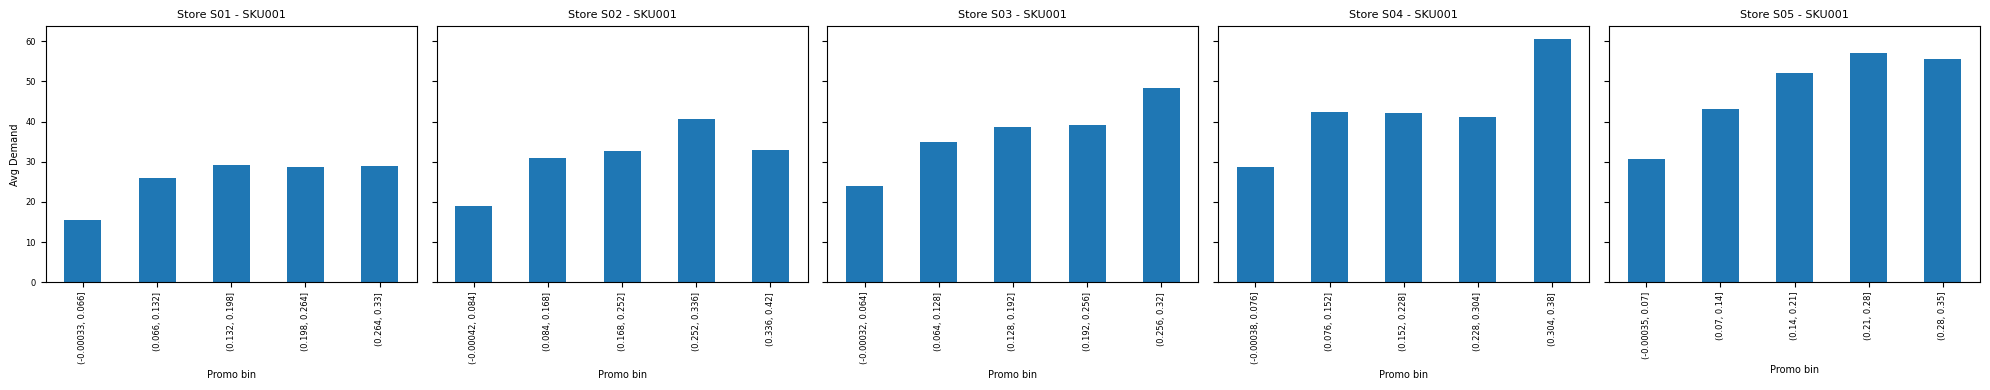

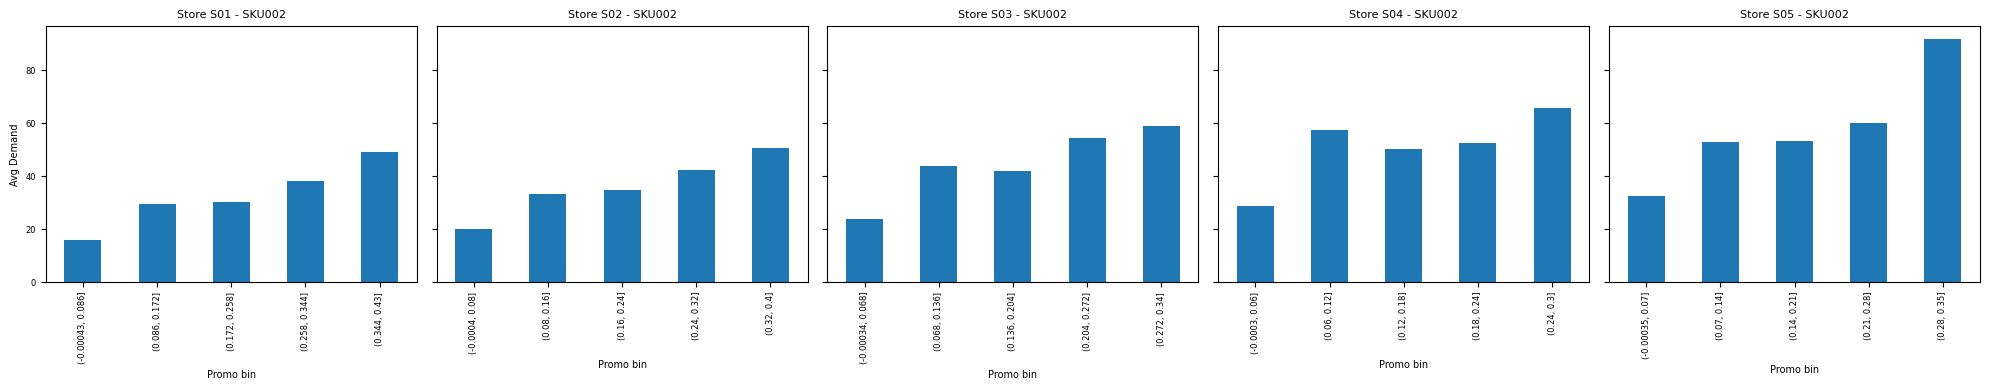

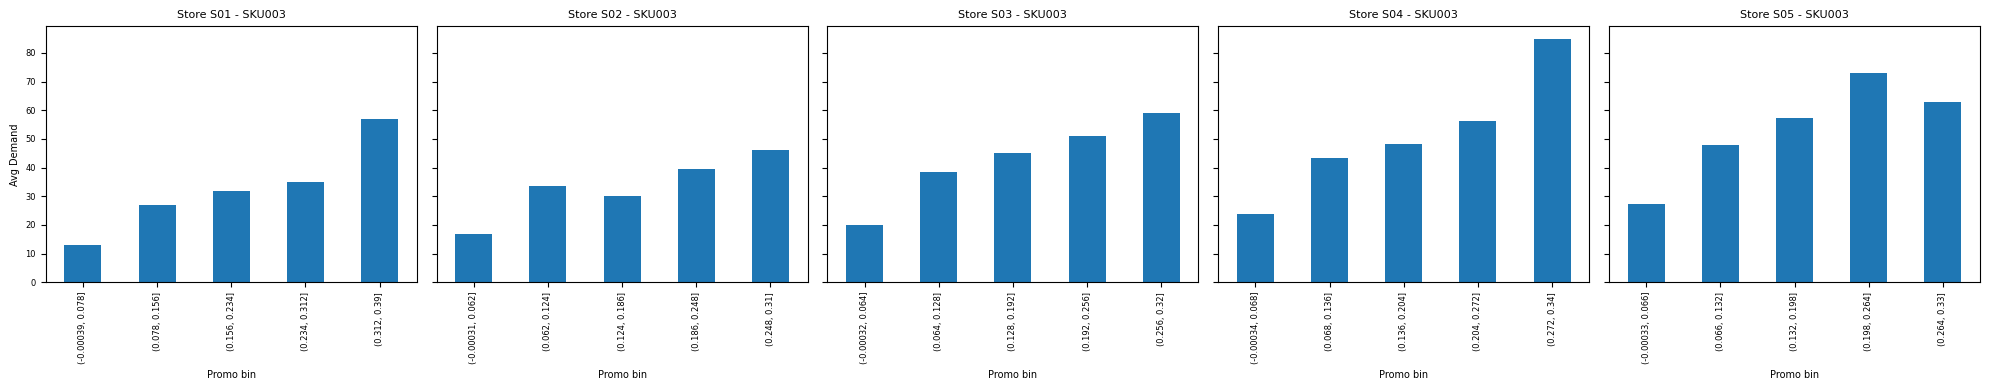

In [27]:
for sk in skus:
    n_stores = len(stores)
    fig, axes = plt.subplots(1, n_stores, figsize=(4*n_stores, 4), sharey=True)

    if n_stores == 1:  # if only 1 store, keep iterable
        axes = [axes]

    for ax, st in zip(axes, stores):
        df_price = df[(df.store_id == st) & (df.sku_id == sk)]

        if df_price.empty:
            ax.set_title(f"Store {st} - {sk}\n(no data)", fontsize=8)
            ax.axis("off")
            continue

        avg = (
            df_price.groupby(pd.cut(df_price["promo_depth"], bins=5))["units_sold"]
            .mean()
        )

        avg.plot(kind="bar", ax=ax)

        ax.set_title(f"Store {st} - {sk}", fontsize=8)
        ax.set_xlabel("Promo bin", fontsize=7)
        ax.set_ylabel("Avg Demand", fontsize=7)
        ax.tick_params(axis="x", labelsize=6)
        ax.tick_params(axis="y", labelsize=6)

    plt.tight_layout()
    plt.show()


### Holiday ~ Demand
Sometimes non-holiday days sell more, could be because of promotion

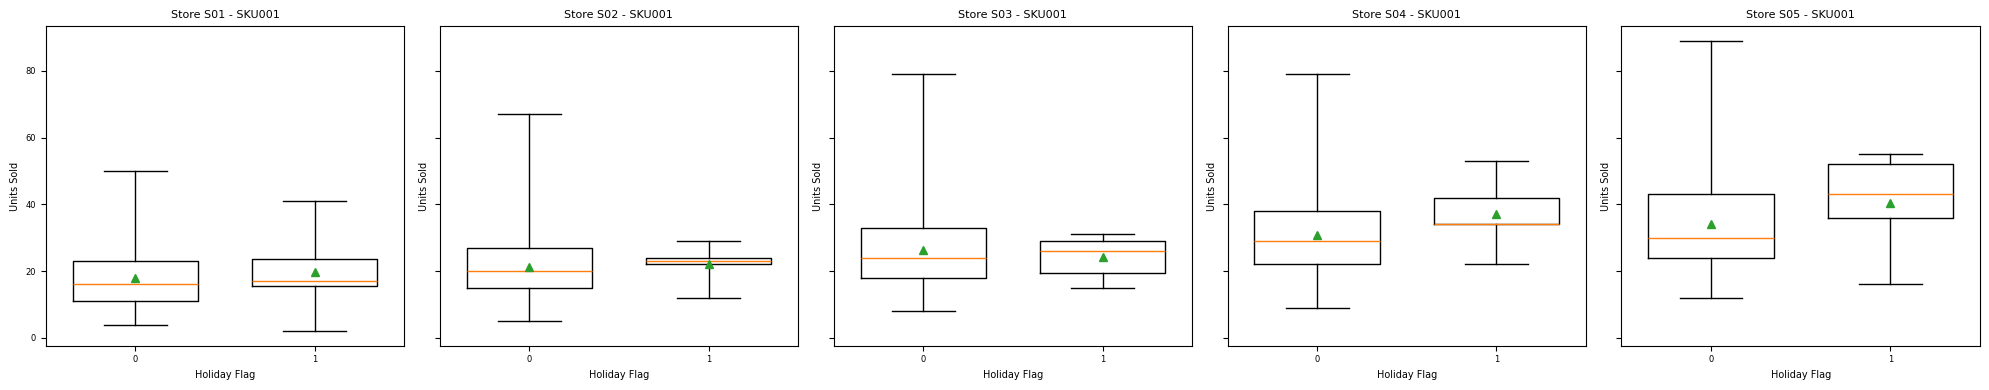

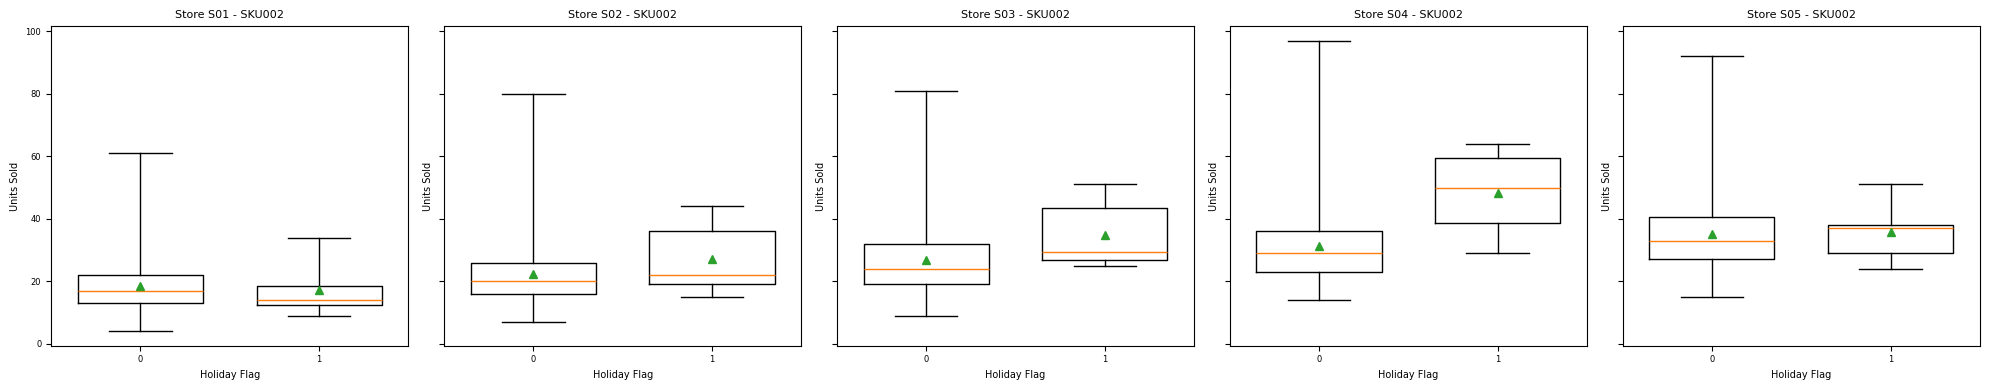

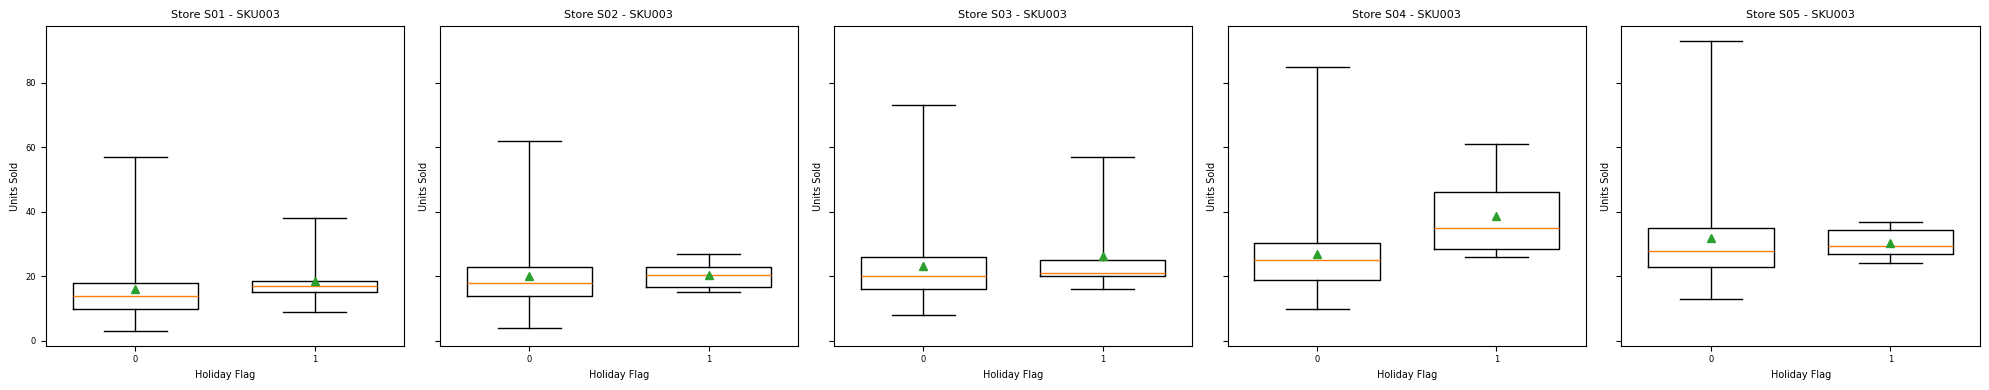

In [28]:
for sk in skus:
    n_stores = len(stores)
    fig, axes = plt.subplots(1, n_stores, figsize=(4*n_stores, 4), sharey=True)

    if n_stores == 1:  # keep iterable if only one store
        axes = [axes]

    for ax, st in zip(axes, stores):
        df_price = df[(df.store_id == st) & (df.sku_id == sk)]

        if df_price.empty:
            ax.set_title(f"Store {st} - {sk}\n(no data)", fontsize=8)
            ax.axis("off")
            continue

        keys = sorted(df_price["holiday_flag"].dropna().unique())
        data = [
            df_price.loc[df_price["holiday_flag"] == k, "units_sold"].values
            for k in keys
        ]

        ax.boxplot(
            data,
            widths=0.7,
            labels=[str(int(k)) for k in keys],
            showmeans=True,
            whis=[0, 100],
        )

        ax.set_title(f"Store {st} - {sk}", fontsize=8)
        ax.set_xlabel("Holiday Flag", fontsize=7)
        ax.set_ylabel("Units Sold", fontsize=7)
        ax.tick_params(axis="x", labelsize=6)
        ax.tick_params(axis="y", labelsize=6)

    plt.tight_layout()
    plt.show()


### Weather ~ Demand

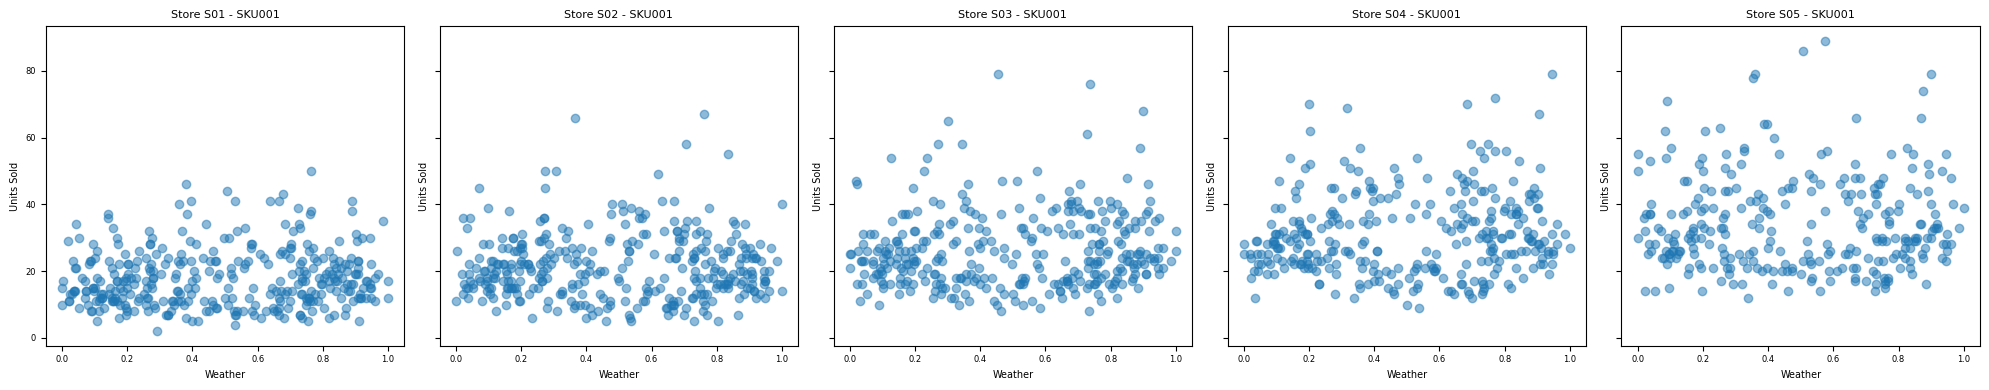

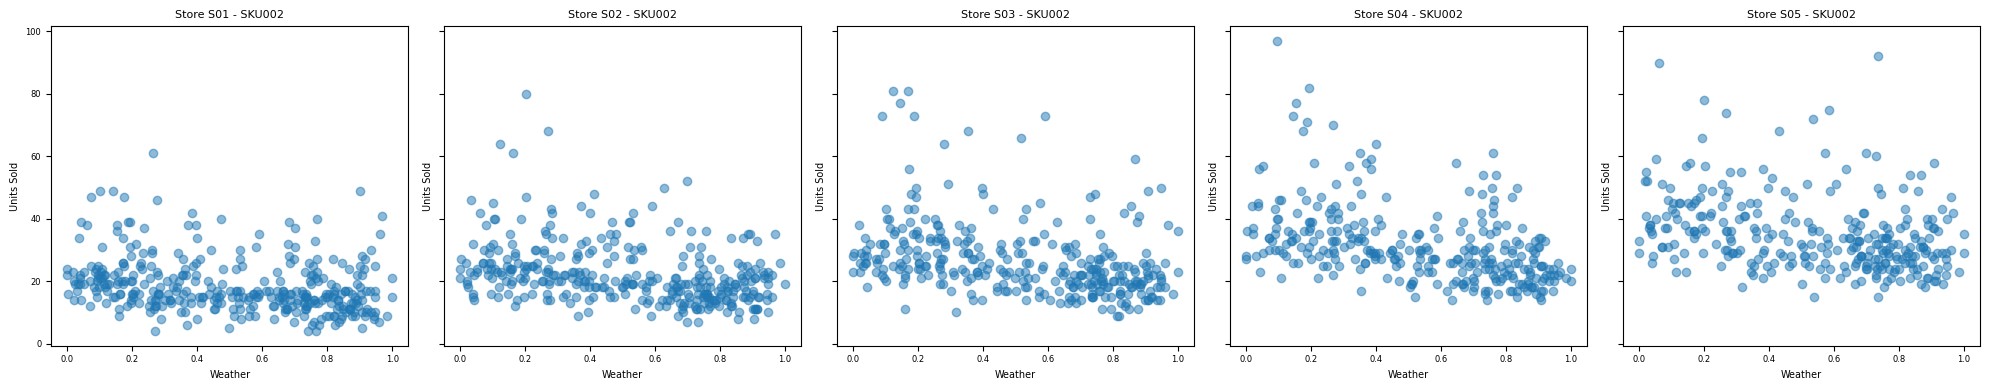

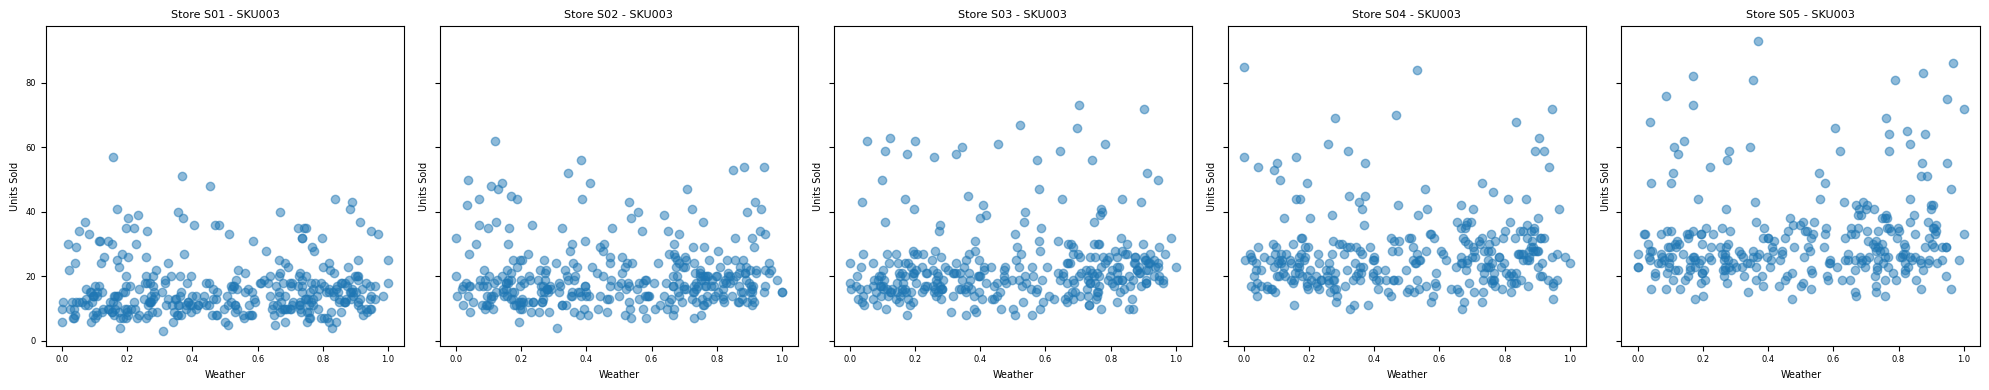

In [29]:
for sk in skus:
    n_stores = len(stores)
    fig, axes = plt.subplots(1, n_stores, figsize=(4*n_stores, 4), sharey=True, sharex=True)

    if n_stores == 1:  # keep iterable
        axes = [axes]

    for ax, st in zip(axes, stores):
        df_price = df[(df.store_id == st) & (df.sku_id == sk)]

        if df_price.empty:
            ax.set_title(f"Store {st} - {sk}\n(no data)", fontsize=8)
            ax.axis("off")
            continue

        ax.scatter(df_price.weather_index, df_price.units_sold, alpha=0.5)

        ax.set_title(f"Store {st} - {sk}", fontsize=8)
        ax.set_xlabel("Weather", fontsize=7)
        ax.set_ylabel("Units Sold", fontsize=7)
        ax.tick_params(axis="x", labelsize=6)
        ax.tick_params(axis="y", labelsize=6)

    plt.tight_layout()
    plt.show()


### Annual patterns ~ Demand

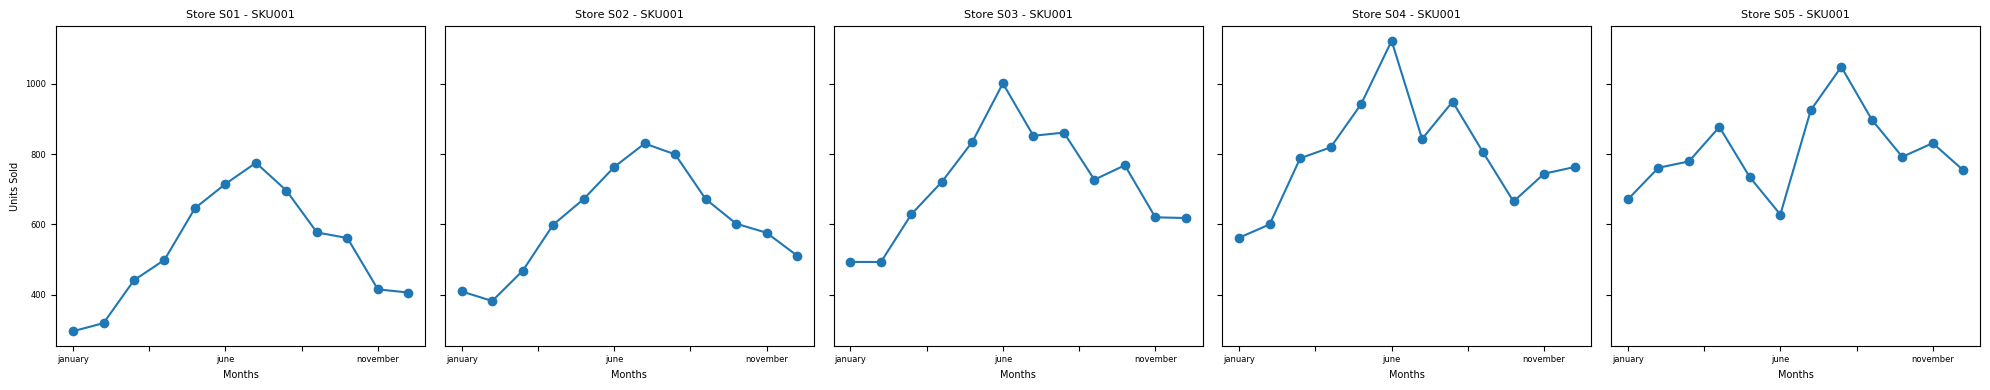

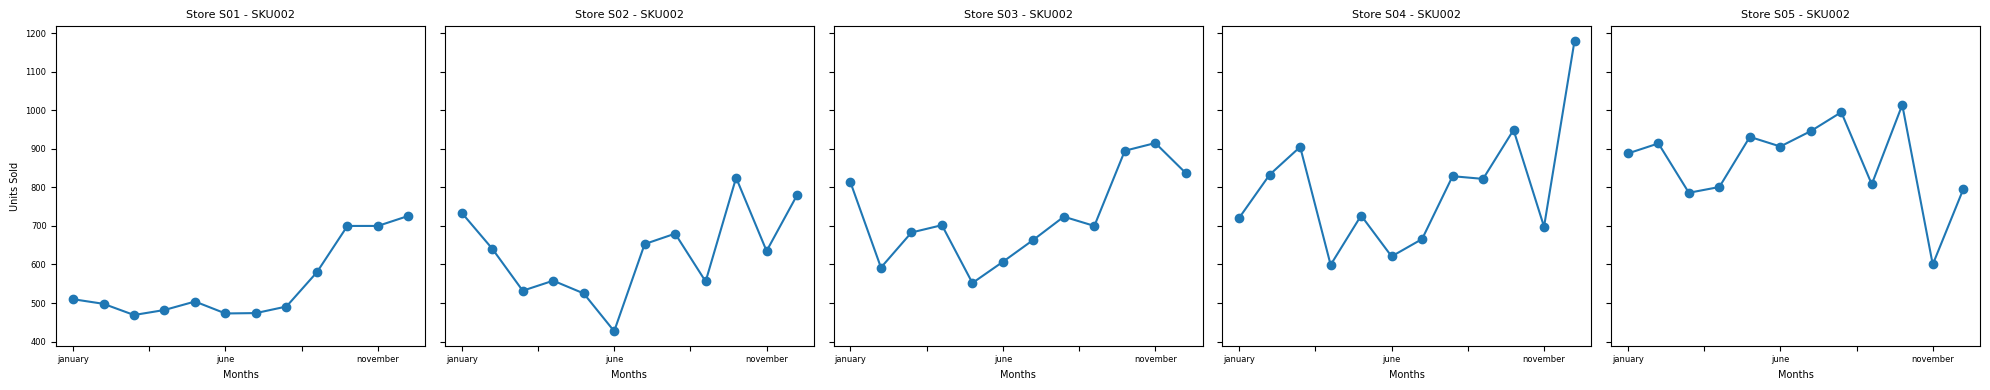

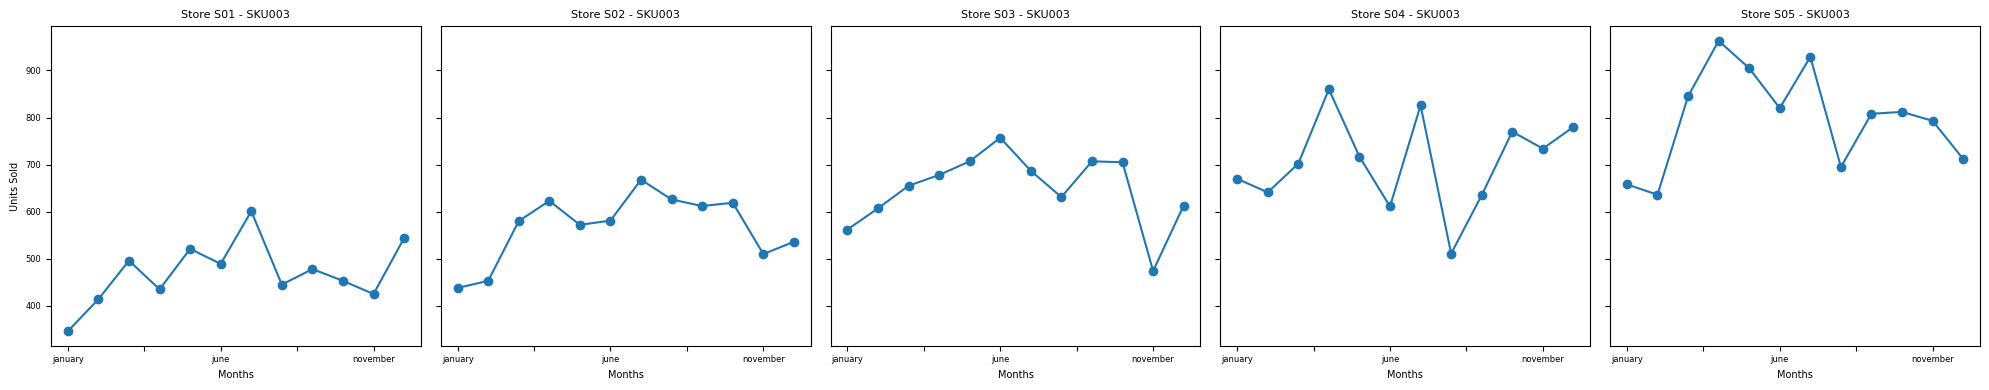

In [30]:
for sk in skus:
    n_stores = len(stores)
    fig, axes = plt.subplots(1, n_stores, figsize=(4*n_stores, 4), sharey=True)

    if n_stores == 1:  # ensure iterable when only 1 store
        axes = [axes]

    for ax, st in zip(axes, stores):
        df_price = df[(df.store_id == st) & (df.sku_id == sk)]

        if df_price.empty:
            ax.set_title(f"Store {st} - {sk}\n(no data)", fontsize=8)
            ax.axis("off")
            continue

        avg = df_price.groupby("month_of_year")["units_sold"].sum()
        avg.plot(kind="line", ax=ax, marker="o")

        ax.set_title(f"Store {st} - {sk}", fontsize=8)
        ax.set_xlabel("Months", fontsize=7)
        ax.set_ylabel("Units Sold", fontsize=7)
        ax.tick_params(axis="x", labelsize=6)
        ax.tick_params(axis="y", labelsize=6)

    plt.tight_layout()
    plt.show()


### Weekly patterns ~ Demand

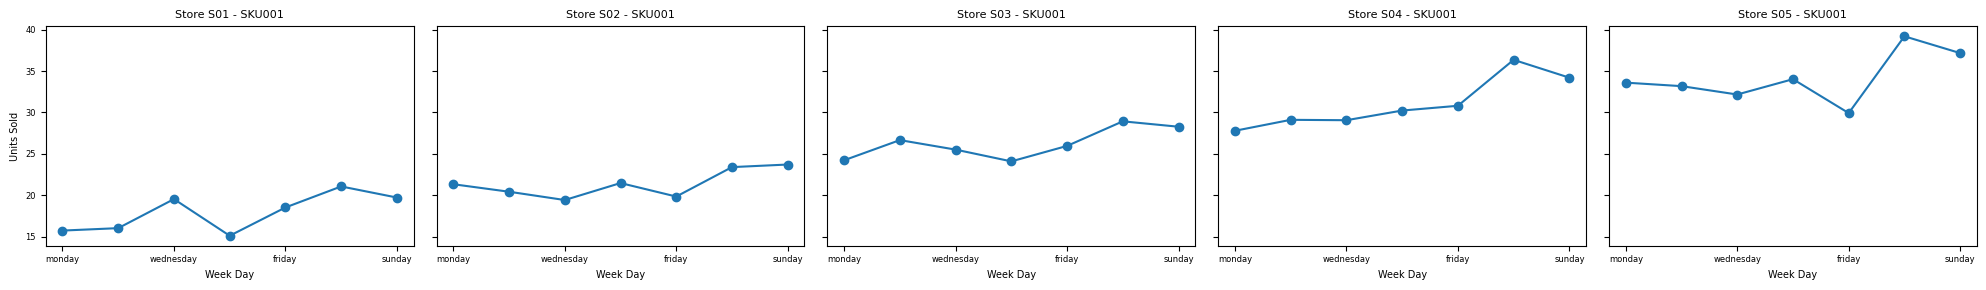

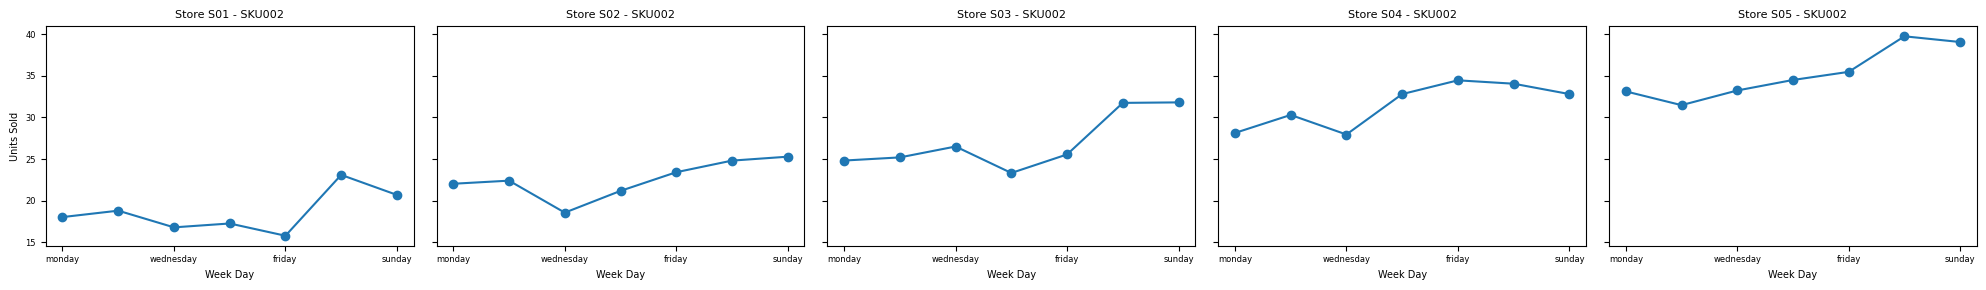

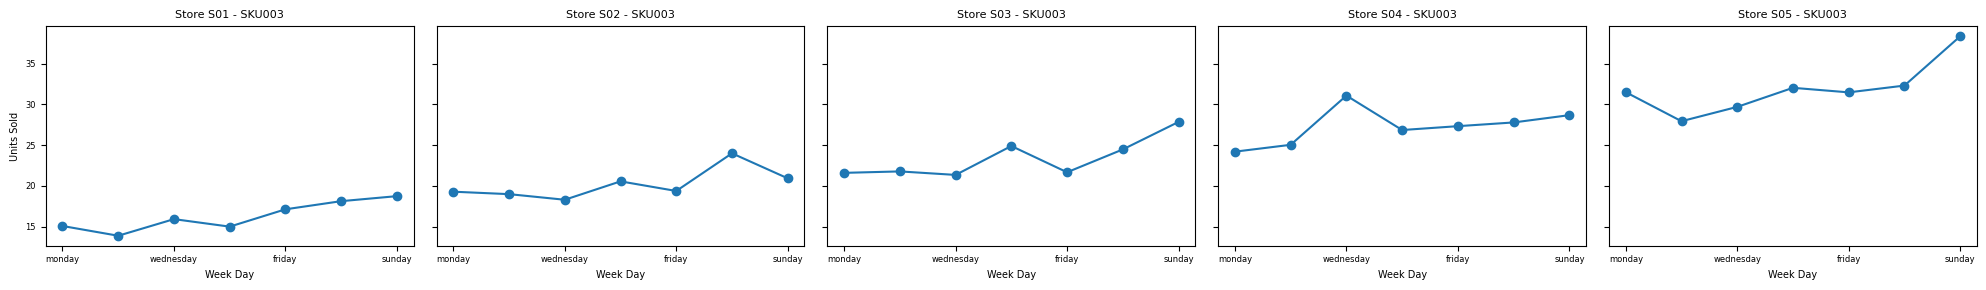

In [31]:
for sk in skus:
    n_stores = len(stores)
    fig, axes = plt.subplots(1, n_stores, figsize=(4*n_stores, 3), sharey=True)

    if n_stores == 1:  # make sure axes is iterable
        axes = [axes]

    for ax, st in zip(axes, stores):
        df_price = df[(df.store_id == st) & (df.sku_id == sk)]

        if df_price.empty:
            ax.set_title(f"Store {st} - {sk}\n(no data)", fontsize=8)
            ax.axis("off")
            continue

        avg = df_price.groupby("day_of_week")["units_sold"].mean()
        avg.plot(kind="line", ax=ax, marker="o")

        ax.set_title(f"Store {st} - {sk}", fontsize=8)
        ax.set_xlabel("Week Day", fontsize=7)
        ax.set_ylabel("Units Sold", fontsize=7)
        ax.tick_params(axis="x", labelsize=6)
        ax.tick_params(axis="y", labelsize=6)

    plt.tight_layout()
    plt.show()

## Simple Price Elasticity Report
price elasticity by SKU and promo effect sizes

In [31]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

def fit_price_comp_promo_by_sku(
    df: pd.DataFrame,
    skus=None,
    robust_se: bool = True,
    se_on: str = "all"  # "all" (default) or "price_only"
):
    """
    Fit per-SKU log-linear regression and return coefficients + SE + CI.

    Args:
      robust_se : bool, default=True
          If True, use HC3 robust SE. If False, use classic homoskedastic SE.
      se_on : str, default="all"
          "all"        -> SE calculated using full design matrix (default, recommended)
          "price_only" -> SE calculated as if regression only had price
    """
    d0 = df.copy()

    num_cols_force = [
        "units_sold","final_price_ln","competitor_price_diff","promo_flag","holiday_flag",
        "final_price","base_price"
    ]
    for c in num_cols_force:
        if c in d0.columns:
            d0[c] = pd.to_numeric(d0[c], errors="coerce")

    calendar_all = [
        'onehot_monday','onehot_tuesday','onehot_wednesday','onehot_thursday','onehot_friday','onehot_saturday',
        'onehot_january','onehot_february','onehot_march','onehot_april','onehot_may','onehot_june',
        'onehot_july','onehot_august','onehot_september','onehot_october','onehot_november'
    ]
    calendar_use = [c for c in calendar_all if c in d0.columns]

    if skus is None:
        skus = d0["sku_id"].dropna().unique().tolist()

    report_rows = []

    for sk in skus:
        d = d0.loc[d0["sku_id"] == sk].copy()
        d["ln_units"] = np.log(pd.to_numeric(d["units_sold"], errors="coerce").clip(lower=1e-9))

        cols_full = ["final_price_ln", "competitor_price_diff", "promo_flag", "holiday_flag"] + calendar_use
        d = d.dropna(subset=cols_full + ["ln_units"]).reset_index(drop=True)
        if len(d) < 10:
            continue

        # always fit with all predictors (to get unbiased coefficients)
        X = d[cols_full].astype(float).values
        y = d["ln_units"].astype(float).values

        lr = LinearRegression(fit_intercept=True).fit(X, y)
        coef = dict(zip(cols_full, lr.coef_))
        intercept = lr.intercept_

        # --- Choose matrix for SE calculation ---
        if se_on == "all":
            Xd = np.column_stack([np.ones(len(X)), X])
            colnames = ["Intercept"] + cols_full
        elif se_on == "price_only":
            X_price = d[["final_price_ln"]].astype(float).values
            Xd = np.column_stack([np.ones(len(X_price)), X_price])
            colnames = ["Intercept", "final_price_ln"]
        else:
            raise ValueError("se_on must be 'all' or 'price_only'")

        params = np.r_[intercept, lr.coef_] if se_on=="all" else None  # only used for resid
        # recompute fitted values & residuals using the same Xd
        if se_on == "all":
            y_hat = Xd @ np.r_[intercept, lr.coef_]
        else:
            # simple regression on price only
            lr_simple = LinearRegression(fit_intercept=True).fit(d[["final_price_ln"]], y)
            y_hat = lr_simple.predict(d[["final_price_ln"]])
        resid = y - y_hat

        n, k = Xd.shape
        XtX = Xd.T @ Xd
        try:
            XtX_inv = np.linalg.inv(XtX)
        except np.linalg.LinAlgError:
            XtX_inv = np.linalg.pinv(XtX)

        if robust_se:
            # HC3
            H_diag = np.sum((Xd @ XtX_inv) * Xd, axis=1)
            denom = np.maximum(1.0 - H_diag, 1e-12)
            w = (resid**2) / (denom**2)
            S = Xd.T @ (Xd * w[:, None])
            cov = XtX_inv @ S @ XtX_inv
        else:
            sigma2 = (resid @ resid) / max(n - k, 1)
            cov = sigma2 * XtX_inv

        se_all = np.sqrt(np.diag(cov))
        price_idx = colnames.index("final_price_ln")
        se_price = float(se_all[price_idx])

        # always report coefficient from full model (to keep it unbiased)
        beta_price = float(coef["final_price_ln"])
        z = 1.96
        ci_lower = beta_price - z * se_price
        ci_upper = beta_price + z * se_price

        report_rows.append({
            "sku_id": sk,
            "nobs": n,
            "elasticity": beta_price,
            "se": se_price,
            "ci_lower": ci_lower,
            "ci_upper": ci_upper,
            "se_type": "HC3" if robust_se else "OLS",
            "se_on": se_on
        })

        print(f"[{sk}] β_price = {beta_price:.3f}, SE={se_price:.3f}, "
              f"CI=({ci_lower:.3f}, {ci_upper:.3f}) "
              f"using {se_on}, {('robust' if robust_se else 'classic')}")

    return pd.DataFrame(report_rows)




# =========================
# 3) Debias units to baseline:
#    price -> base_price, competitor_price_diff -> 0, promo_flag -> 0
#    Uses raw coefficients from the model above.
# =========================
def debias_units_using_coefs(df: pd.DataFrame,
                             beta_price_dict: dict,
                             beta_comp_dict: dict,
                             beta_promo_dict: dict):
    """
    Implements the log-linear model:
      ln(Q) = β0 + β_price*ln(final_price) + β_comp*competitor_price_diff + β_promo*promo_flag + ...

    Baseline:
      final_price = base_price
      competitor_price_diff = 0
      promo_flag = 0

    Factors:
      factor_price = (final_price / base_price) ** β_price
      factor_comp  = exp(β_comp * competitor_price_diff)
      factor_promo = exp(β_promo * promo_flag)

    units_pure = units_sold / (factor_price * factor_comp * factor_promo)
    """
    out = df.copy()

    # numeric safety
    for c in ["units_sold","final_price","base_price","competitor_price_diff","promo_flag"]:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce")

    # map raw coefficients
    out["β_price"] = out["sku_id"].map(beta_price_dict).astype(float)
    out["β_comp"]  = out["sku_id"].map(beta_comp_dict).astype(float)
    out["β_promo"] = out["sku_id"].map(beta_promo_dict).astype(float)

    # price factor
    price_ratio = out["final_price"] / out["base_price"]
    out["factor_price"] = np.power(price_ratio, out["β_price"])

    # competitor factor (competitor_price_diff already in [-1, 1] range)
    out["factor_comp"] = np.exp(out["β_comp"] * out["competitor_price_diff"])

    # promo factor
    out["factor_promo"] = np.exp(out["β_promo"] * out["promo_flag"])

    # combined and debiased
    out["adj_factor"] = out["factor_price"] * out["factor_comp"] * out["factor_promo"]
    out["units_pure"] = out["units_sold"] / out["adj_factor"]

    return out

In [32]:
# beta_price_dict, beta_comp_dict, beta_promo_dict, report = fit_price_comp_promo_by_sku(df, skus=skus)
# df_debiased = debias_units_using_coefs(df, beta_price_dict, beta_comp_dict, beta_promo_dict)

# Full model (all predictors), robust SE (default, recommended)
rep1 = fit_price_comp_promo_by_sku(df, robust_se=True, se_on="all")

# Only price predictor, robust SE
rep2 = fit_price_comp_promo_by_sku(df, robust_se=True, se_on="price_only")

# Only price predictor, classic SE
rep3 = fit_price_comp_promo_by_sku(df, robust_se=False, se_on="price_only")


[SKU001] β_price = -0.325, SE=0.374, CI=(-1.059, 0.408) using all, robust
[SKU002] β_price = -0.655, SE=0.380, CI=(-1.399, 0.089) using all, robust
[SKU003] β_price = -1.584, SE=0.374, CI=(-2.317, -0.851) using all, robust
[SKU001] β_price = -0.325, SE=0.122, CI=(-0.564, -0.087) using price_only, robust
[SKU002] β_price = -0.655, SE=0.119, CI=(-0.887, -0.423) using price_only, robust
[SKU003] β_price = -1.584, SE=0.105, CI=(-1.790, -1.378) using price_only, robust
[SKU001] β_price = -0.325, SE=0.130, CI=(-0.580, -0.071) using price_only, classic
[SKU002] β_price = -0.655, SE=0.126, CI=(-0.902, -0.408) using price_only, classic
[SKU003] β_price = -1.584, SE=0.119, CI=(-1.818, -1.350) using price_only, classic


- Price sensitivity: SKU003 > SKU002 > SKU001

In [22]:
# =========================
# New imports
# =========================
import numpy as np
import pandas as pd
import statsmodels.api as sm
from typing import Optional, Sequence

# =========================
# Helper: safe log of units with zero-guard
# =========================
def _safe_log_units(s: pd.Series) -> pd.Series:
    s_num = pd.to_numeric(s, errors="coerce")
    return np.log(s_num.clip(lower=1e-9))

# =========================
# 1) Fit per-SKU OLS with robust SE (HC3 by default)
#    ln_units ~ ln(final_price) + competitor_price_diff + promo_flag + holiday_flag + calendar dummies + const
#    Returns a tidy DataFrame with coef, SE, CI, R2, nobs for each SKU.
# =========================
def elasticity_report_per_sku(
    df: pd.DataFrame,
    skus: Optional[Sequence] = None,
    cluster_on: Optional[str] = None,   # e.g., "store_id" or "week_id"; if None => robust HC3
    min_rows: int = 25,
    price_col_ln: str = "final_price_ln",
    comp_col: str = "competitor_price_diff",
    promo_col: str = "promo_flag",
    holiday_col: str = "holiday_flag",
    add_calendar: bool = True,
    calendar_candidates: Optional[Sequence[str]] = None,
) -> pd.DataFrame:
    """
    Build per-SKU elasticity table with 95% confidence intervals.

    df columns needed minimally:
      sku_id, units_sold, final_price_ln, competitor_price_diff, promo_flag, holiday_flag
      + optional calendar one-hots (e.g., onehot_monday,... onehot_november)

    Args:
      cluster_on: if provided, uses cluster-robust covariance by this column (within each SKU).
                  If None, uses heteroskedasticity-robust 'HC3'.
      min_rows  : minimum rows per SKU to attempt a fit.
      add_calendar: include any calendar dummies found in df.
      calendar_candidates: explicit list of calendar cols; if None, uses a sensible default.

    Returns:
      DataFrame with columns:
        sku_id, nobs, r2, mean_price, mean_units,
        elasticity, se, ci_lower, ci_upper,
        promo_effect_pct, comp_coef
    """
    d0 = df.copy()

    # force numerics
    force_num = ["units_sold", price_col_ln, comp_col, promo_col, holiday_col, "final_price", "base_price"]
    for c in force_num:
        if c in d0.columns:
            d0[c] = pd.to_numeric(d0[c], errors="coerce")

    # Calendar dummies autodetect
    if calendar_candidates is None:
        calendar_candidates = [
            'onehot_monday','onehot_tuesday','onehot_wednesday','onehot_thursday','onehot_friday','onehot_saturday',
            'onehot_january','onehot_february','onehot_march','onehot_april','onehot_may','onehot_june',
            'onehot_july','onehot_august','onehot_september','onehot_october','onehot_november'
            # (December is baseline if you built dummies that way, or just missing)
        ]
    cal_use = [c for c in calendar_candidates if c in d0.columns] if add_calendar else []

    # target
    d0["ln_units"] = _safe_log_units(d0["units_sold"])

    # SKU set
    if skus is None:
        skus = d0["sku_id"].dropna().unique().tolist()

    rows = []
    for sk in skus:
        d = d0.loc[d0["sku_id"] == sk].copy()

        cols_X = [price_col_ln, comp_col, promo_col, holiday_col] + cal_use
        needed = cols_X + ["ln_units"]
        d = d.dropna(subset=needed).reset_index(drop=True)

        if len(d) < min_rows:
            continue

        # Regressors + intercept
        X = d[cols_X].astype(float)
        X = sm.add_constant(X, has_constant="add")
        y = d["ln_units"].astype(float)

        # Fit OLS
        model = sm.OLS(y, X)
        if cluster_on is not None and (cluster_on in d.columns):
            # Cluster-robust SE
            res = model.fit(cov_type="cluster", cov_kwds={"groups": d[cluster_on].astype("category")})
        else:
            # Heteroskedasticity-robust
            res = model.fit(cov_type="HC3")

        # Extract elasticity (coef on ln(price))
        if price_col_ln not in res.params.index:
            # singular design or dropped col
            continue

        beta_price = float(res.params[price_col_ln])
        se_price   = float(res.bse[price_col_ln])
        # 95% CI with normal approx (large-sample); for small n, you can switch to t-crit with res.df_resid
        z = 1.96
        ci_lo = beta_price - z * se_price
        ci_hi = beta_price + z * se_price

        # Promo & competitor interpretability
        beta_promo = float(res.params.get(promo_col, np.nan))
        promo_effect_pct = (np.exp(beta_promo) - 1.0) * 100.0 if np.isfinite(beta_promo) else np.nan

        beta_comp = float(res.params.get(comp_col, np.nan))  # units are per 1.0 of competitor diff
        # If competitor_price_diff is in fraction points (e.g., +0.05 = +5% more expensive than comp),
        # you can translate to % impact at a reference diff if desired.

        rows.append({
            "sku_id": sk,
            "nobs": int(res.nobs),
            "r2": float(res.rsquared),
            "mean_price": float(d["final_price"].mean()) if "final_price" in d.columns else np.nan,
            "mean_units": float(d["units_sold"].mean()),
            "elasticity": beta_price,
            "se": se_price,
            "ci_lower": ci_lo,
            "ci_upper": ci_hi,
            "promo_effect_pct": promo_effect_pct,
            "comp_coef": beta_comp,
        })

    report = pd.DataFrame(rows).sort_values(["sku_id"]).reset_index(drop=True)
    return report

# =========================
# 2) Convenience: write report to CSV
# =========================
def save_elasticity_report(df: pd.DataFrame, path: str) -> None:
    df.to_csv(path, index=False)
    print(f"✅ Elasticity report saved: {path}")


In [23]:
report = elasticity_report_per_sku(
    df,
    cluster_on="store_id",   # or "week_id" if you have it; else None for HC3
    min_rows=25
)

In [24]:
report

,sku_id,nobs,r2,mean_price,mean_units,elasticity,se,ci_lower,ci_upper,promo_effect_pct,comp_coef
0,SKU001,1618,0.516877,10.146329,25.677998,-0.325420,0.207310,-0.731748,0.080909,27.773176,0.919086
1,SKU002,1613,0.415803,15.080347,26.516429,-0.654987,0.122914,-0.895898,-0.414075,38.867203,0.650052
2,SKU003,1632,0.467984,21.370037,23.456495,-1.584249,0.186702,-1.950184,-1.218314,47.118902,0.418028


# Baseline forecasting model

In [25]:
df.columns

Index(['date', 'store_id', 'sku_id', 'base_price', 'promo_flag', 'promo_depth',
       'final_price', 'competitor_price', 'holiday_flag', 'weather_index',
       'week_of_year', 'units_sold', 'revenue', 'margin', 'stock_cap',
       'stockout_flag', 'set', 'day_of_week', 'month_of_year', 'season',
       'sold_yesterday', 'sold_last_week', 'units_sold_ma7', 'units_sold_ma30',
       'final_price_ln', 'competitor_price_diff', 'flag_promo_1stday',
       'onehot_monday', 'onehot_tuesday', 'onehot_wednesday',
       'onehot_thursday', 'onehot_friday', 'onehot_saturday', 'onehot_sunday',
       'onehot_january', 'onehot_february', 'onehot_march', 'onehot_april',
       'onehot_may', 'onehot_june', 'onehot_july', 'onehot_august',
       'onehot_september', 'onehot_october', 'onehot_november',
       'onehot_december', 'onehot_spring', 'onehot_summer', 'onehot_autumn',
       'onehot_winter'],
      dtype='object')

In [26]:
from utils.schema import FEATURE_COLS, TARGET_COL

In [27]:
# df already excluded the stock out
X_train = df[df.set == 'train'][FEATURE_COLS]
y_train = df[df.set == 'train'][TARGET_COL]
X_test = df[df.set == 'test'][FEATURE_COLS]
y_test = df[df.set == 'test'][TARGET_COL]

In [28]:
X_train

,store_id,sku_id,base_price,promo_flag,promo_depth,final_price,competitor_price,holiday_flag,weather_index,day_of_week,month_of_year,season,sold_yesterday,sold_last_week,units_sold_ma7,units_sold_ma30,flag_promo_1stday,final_price_ln,competitor_price_diff
0,S01,SKU001,10.49,0,0.0,10.49,10.02,1,0.291,monday,january,winter,-1,-1,2.000000,2.000000,0,2.350422,-0.044805
1,S01,SKU001,10.49,0,0.0,10.49,10.54,0,0.459,tuesday,january,winter,2,-1,6.500000,6.500000,0,2.350422,0.004766
2,S01,SKU001,10.49,0,0.0,10.49,10.60,0,0.337,wednesday,january,winter,11,-1,8.000000,8.000000,0,2.350422,0.010486
3,S01,SKU001,10.49,0,0.0,10.49,10.99,0,0.381,thursday,january,winter,11,-1,7.500000,7.500000,0,2.350422,0.047664
4,S01,SKU001,10.49,0,0.0,10.49,11.55,0,0.398,friday,january,winter,6,-1,7.000000,7.000000,0,2.350422,0.101049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4782,S05,SKU003,21.99,0,0.0,21.99,20.05,0,0.146,wednesday,september,autumn,30,28,36.857143,32.300000,0,3.090588,-0.088222
4783,S05,SKU003,21.99,0,0.0,21.99,19.35,0,0.160,thursday,september,autumn,19,52,32.714286,32.300000,0,3.090588,-0.120055
4784,S05,SKU003,21.99,0,0.0,21.99,20.79,0,0.176,saturday,september,autumn,34,31,31.714286,32.533333,0,3.090588,-0.054570
4785,S05,SKU003,21.99,0,0.0,21.99,21.32,0,0.090,sunday,september,autumn,23,62,27.714286,32.833333,0,3.090588,-0.030468


In [29]:
df[FEATURE_COLS]

,store_id,sku_id,base_price,promo_flag,promo_depth,final_price,competitor_price,holiday_flag,weather_index,day_of_week,month_of_year,season,sold_yesterday,sold_last_week,units_sold_ma7,units_sold_ma30,flag_promo_1stday,final_price_ln,competitor_price_diff
0,S01,SKU001,10.49,0,0.00,10.49,10.02,1,0.291,monday,january,winter,-1,-1,2.000000,2.000000,0,2.350422,-0.044805
1,S01,SKU001,10.49,0,0.00,10.49,10.54,0,0.459,tuesday,january,winter,2,-1,6.500000,6.500000,0,2.350422,0.004766
2,S01,SKU001,10.49,0,0.00,10.49,10.60,0,0.337,wednesday,january,winter,11,-1,8.000000,8.000000,0,2.350422,0.010486
3,S01,SKU001,10.49,0,0.00,10.49,10.99,0,0.381,thursday,january,winter,11,-1,7.500000,7.500000,0,2.350422,0.047664
4,S01,SKU001,10.49,0,0.00,10.49,11.55,0,0.398,friday,january,winter,6,-1,7.000000,7.000000,0,2.350422,0.101049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4858,S05,SKU003,21.99,0,0.00,21.99,20.67,0,0.280,wednesday,december,winter,32,26,27.571429,34.600000,0,3.090588,-0.060027
4859,S05,SKU003,21.99,0,0.00,21.99,22.07,0,0.363,thursday,december,winter,23,26,26.571429,33.733333,0,3.090588,0.003638
4860,S05,SKU003,21.99,0,0.00,21.99,23.16,0,0.386,saturday,december,winter,65,51,29.857143,33.700000,0,3.090588,0.053206
4861,S05,SKU003,21.99,1,0.33,14.73,21.55,0,0.355,monday,december,winter,31,18,40.857143,35.300000,0,2.689886,0.463001


In [30]:
modeling.fit(X_train, y_train)

[0]	validation_0-rmse:12.22233
[1]	validation_0-rmse:11.81680
[2]	validation_0-rmse:11.42325
[3]	validation_0-rmse:11.05457
[4]	validation_0-rmse:10.69661
[5]	validation_0-rmse:10.37041
[6]	validation_0-rmse:10.06502
[7]	validation_0-rmse:9.76515
[8]	validation_0-rmse:9.48395
[9]	validation_0-rmse:9.22369
[10]	validation_0-rmse:8.99263
[11]	validation_0-rmse:8.76910
[12]	validation_0-rmse:8.56778
[13]	validation_0-rmse:8.36721
[14]	validation_0-rmse:8.17325
[15]	validation_0-rmse:8.00891
[16]	validation_0-rmse:7.84312
[17]	validation_0-rmse:7.68453
[18]	validation_0-rmse:7.53516
[19]	validation_0-rmse:7.40407
[20]	validation_0-rmse:7.27960
[21]	validation_0-rmse:7.15726
[22]	validation_0-rmse:7.04895
[23]	validation_0-rmse:6.94810
[24]	validation_0-rmse:6.85409
[25]	validation_0-rmse:6.77037
[26]	validation_0-rmse:6.69755
[27]	validation_0-rmse:6.62611
[28]	validation_0-rmse:6.55353
[29]	validation_0-rmse:6.47704
[30]	validation_0-rmse:6.40335
[31]	validation_0-rmse:6.35241
[32]	valida

'forecaster_xgboost_20250919_163246.pkl'

In [31]:
modeling.validate('forecaster_xgboost_20250919_163246.pkl', X_train, y_train)

Validation metrics for forecaster_xgboost_20250919_163246.pkl:
  R^2  : 0.9052
  RMSE : 3.815750
  MAPE : 14.64%


{'r2': 0.9052414298057556,
 'rmse': 3.8157503624519578,
 'mape_pct': 14.643081868283096}

In [32]:
modeling.validate('forecaster_xgboost_20250919_163246.pkl', X_test, y_test)

Validation metrics for forecaster_xgboost_20250919_163246.pkl:
  R^2  : 0.8098
  RMSE : 5.820830
  MAPE : 19.32%


{'r2': 0.809754490852356,
 'rmse': 5.820829596366948,
 'mape_pct': 19.316901922453283}

- There is a clear overfitting sight due to unable to model the seasonality

In [33]:
modeling.validate('forecaster_xgboost_20250919_163246.pkl', df[(df.set == 'test') & (df.sku_id == 'SKU001')][FEATURE_COLS], df[(df.set == 'test') & (df.sku_id == 'SKU001')][TARGET_COL])

Validation metrics for forecaster_xgboost_20250919_163246.pkl:
  R^2  : 0.7804
  RMSE : 4.690632
  MAPE : 19.23%


{'r2': 0.780387282371521,
 'rmse': 4.69063229493572,
 'mape_pct': 19.22853671425081}

In [34]:
modeling.validate('forecaster_xgboost_20250919_163246.pkl', df[(df.set == 'test') & (df.sku_id == 'SKU002')][FEATURE_COLS], df[(df.set == 'test') & (df.sku_id == 'SKU002')][TARGET_COL])

Validation metrics for forecaster_xgboost_20250919_163246.pkl:
  R^2  : 0.7027
  RMSE : 7.443591
  MAPE : 15.25%


{'r2': 0.7026761770248413,
 'rmse': 7.443591276153318,
 'mape_pct': 15.254622793827735}

In [35]:
modeling.validate('forecaster_xgboost_20250919_163246.pkl', df[(df.set == 'test') & (df.sku_id == 'SKU003')][FEATURE_COLS], df[(df.set == 'test') & (df.sku_id == 'SKU003')][TARGET_COL])

Validation metrics for forecaster_xgboost_20250919_163246.pkl:
  R^2  : 0.8394
  RMSE : 5.246954
  MAPE : 22.89%


{'r2': 0.8394312262535095,
 'rmse': 5.246954443252336,
 'mape_pct': 22.890278263908588}

# Optimizer
Maximize revenue subject to price bounds & promo constraints

In [18]:
price_plan = optimize_price_plan('submission/src/models/forecaster_xgboost_20250919_163246.pkl', '2024-03-01', 30)
price_plan

=== Optimization Summary ===
Horizon days         : 30
Date range           : 2024-03-01 → 2024-03-30
Total baseline rev   : 72,405.38
Total optimized rev  : 82,793.53
Revenue lift         : 10,388.15 (14.35%)
Exported price plan to c:\Users\thi.n\Documents\Projects\simcel\submission\src\pricing\price_plan_20240301_30days_20250919_180322.csv


,date,store_id,sku_id,final_price,promo_depth,pred_units,revenue,is_promo,base_price,baseline_units,baseline_revenue,uplift_revenue
0,2024-03-01,S01,SKU001,10.490000,0.000000,10.263353,107.662577,0,10.49,10.263353,107.662577,0.000000
1,2024-03-01,S01,SKU002,15.490000,0.000000,10.154909,157.299542,0,15.49,10.154909,157.299542,0.000000
2,2024-03-01,S01,SKU003,21.990000,0.000000,9.783714,215.143877,0,21.99,9.783714,215.143877,0.000000
3,2024-03-01,S02,SKU001,10.490000,0.000000,10.263353,107.662577,0,10.49,10.263353,107.662577,0.000000
4,2024-03-01,S02,SKU002,15.490000,0.000000,10.154909,157.299542,0,15.49,10.154909,157.299542,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
445,2024-03-30,S04,SKU002,13.424667,0.133333,21.395229,287.223822,1,15.49,10.619044,164.488996,122.734826
446,2024-03-30,S04,SKU003,17.592000,0.200000,26.141277,459.877350,1,21.99,10.493504,230.752144,229.125207
447,2024-03-30,S05,SKU001,9.091333,0.133333,19.432932,176.671262,1,10.49,10.772678,113.005396,63.665865
448,2024-03-30,S05,SKU002,13.424667,0.133333,21.395229,287.223822,1,15.49,10.619044,164.488996,122.734826


In [19]:
# Manually calculate the revenue from the ground truth file
df0[(df0.date>=datetime.datetime(2024,3,1)) & (df0.date<=datetime.datetime(2024,3,30))]['revenue'].sum()

np.float64(154945.89)

In [20]:
# Manually calculate the revenue from the ground truth file
df0[(df0.date>=datetime.datetime(2024,3,1)) & (df0.date<=datetime.datetime(2024,3,30))]\
    .groupby(['sku_id'])['promo_flag'].sum()

# different assumptions

sku_id
SKU001    30
SKU002    18
SKU003    34
Name: promo_flag, dtype: Int64

## Times Series Modeling (trial-only)

                                     SARIMAX Results                                     
Dep. Variable:                        units_pure   No. Observations:                  274
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -756.330
Date:                           Thu, 11 Sep 2025   AIC                           1536.660
Time:                                   23:21:30   BIC                           1579.249
Sample:                               01-01-2024   HQIC                          1553.787
                                    - 09-30-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3297      1.315      1.011      0.312      -1.248       3.908
x2           -10.0228      9.185     -1.091

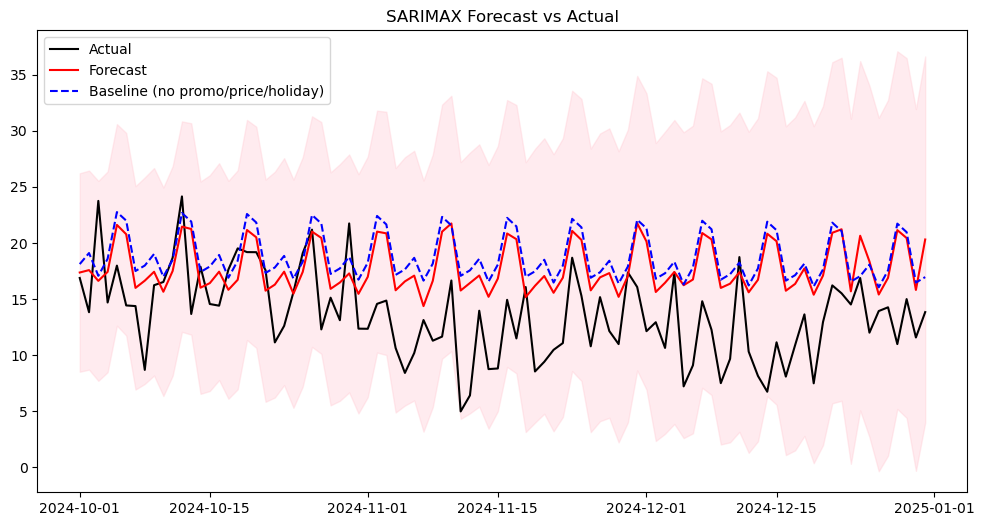

In [35]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ===============================
# 1) Prepare Data
# ===============================
df = df0.copy()

# Ensure datetime and sort
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

# Pick one Store/SKU (otherwise wrap in a loop)
df = df[(df["store_id"]=="S01") & (df["sku_id"]=="SKU001")].copy()

# Index by date with daily frequency
df = df.set_index("date").asfreq("D")

# -------------------------------
# Engineer promo chain features (optional)
# -------------------------------
pf = df["promo_flag"].fillna(0).astype(int)
df["promo_first_day"] = ((pf == 1) & (pf.shift(1).fillna(0) == 0)).astype(int)
df["promo_cont"] = ((pf == 1) & (pf.shift(1).fillna(0) == 1)).astype(int)

# -------------------------------
# Select features
# -------------------------------
exog_cols = [
    # "final_price",
    "promo_flag",
    "promo_depth",
    "promo_first_day",
    "promo_cont",
    "holiday_flag",
    # "competitor_price",
    "weather_index",
    "stockout_flag",
]
exog_cols = [c for c in exog_cols if c in df.columns]

# Convert to numeric (avoid object dtype issue)
for c in exog_cols + ["units_pure"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Split train/test by `set` column
train = df[df["set"]=="train"].copy()
test  = df[df["set"]=="test"].copy()

y_train = train["units_pure"].astype(float)
y_test  = test["units_pure"].astype(float)

X_train = train[exog_cols].astype(float)
X_test  = test[exog_cols].astype(float)

# Drop rows with NA in training
mask = (~y_train.isna()) & (~X_train.isna().any(axis=1))
y_train = y_train.loc[mask]
X_train = X_train.loc[mask]

# Fill missing in test exog (simple ffill)
X_test = X_test.ffill()

# ===============================
# 2) Fit SARIMAX
# ===============================
order = (1,1,1)
seasonal_order = (1,1,1,7)  # weekly seasonality

model = sm.tsa.SARIMAX(
    endog=y_train,
    exog=X_train.to_numpy(dtype="float64"),
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
    missing="drop"
)
results = model.fit(disp=False)
print(results.summary())

# ===============================
# 3) Forecast on Test Set
# ===============================
forecast = results.get_forecast(steps=len(y_test), exog=X_test.to_numpy(dtype="float64"))
y_pred = forecast.predicted_mean
y_true = y_test.loc[y_pred.index]

# ===============================
# 4) Accuracy Metrics
# ===============================
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import r2_score

r2 = r2_score(y_true, y_pred)

print("\nModel Accuracy on Test Set:")
print(f"MAE   : {mae:.2f}")
print(f"RMSE  : {rmse:.2f}")
print(f"MAPE  : {mape:.2f}%")
print(f"R²    : {r2:.3f}")


# ===============================
# 5) Baseline (neutral scenario)
# ===============================
X_base = X_test.copy()
if "promo_flag" in X_base:       X_base["promo_flag"] = 0
if "promo_depth" in X_base:      X_base["promo_depth"] = 0.0
if "promo_first_day" in X_base:  X_base["promo_first_day"] = 0
if "promo_cont" in X_base:       X_base["promo_cont"] = 0
if "holiday_flag" in X_base:     X_base["holiday_flag"] = 0
# if "final_price" in X_base:      X_base["final_price"] = float(train["final_price"].mean())
# if "competitor_price" in X_base: X_base["competitor_price"] = float(train["competitor_price"].mean())
if "weather_index" in X_base:      X_base["weather_index"] = float(train["weather_index"].mean())
if "stockout_flag" in X_base:     X_base["stockout_flag"] = 0

baseline_pred = results.get_forecast(steps=len(y_test), exog=X_base.to_numpy(dtype="float64")).predicted_mean

# ===============================
# 6) Plot Results
# ===============================
plt.figure(figsize=(12,6))
plt.plot(y_true.index, y_true, label="Actual", color="black")
plt.plot(y_pred.index, y_pred, label="Forecast", color="red")
plt.plot(baseline_pred.index, baseline_pred, label="Baseline (no promo/price/holiday)", color="blue", linestyle="--")
plt.fill_between(y_pred.index,
                 forecast.conf_int()["lower units_pure"],
                 forecast.conf_int()["upper units_pure"],
                 color="pink", alpha=0.3)
plt.legend()
plt.title("SARIMAX Forecast vs Actual")
plt.show()
